In [3]:
# ============================
# Step 1: Import Libraries
# ============================
import os
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification, AutoFeatureExtractor, ViTForImageClassification
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from transformers import DeiTForImageClassification

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

C:\Users\Muhammad Umar\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [4]:
# ============================
# Step 2: Dataset and Preprocessing
# ============================
class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None, labeled=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.labeled = labeled

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.labeled:
            return image, self.labels[idx]
        else:
            return image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_dir = r"E:\\1 Paper MCT\\Cutting Tool Paper\\Dataset\\cutting tool data\\test_data_40_images"
all_image_paths = []
all_labels = []
class_to_idx = {class_name: idx for idx, class_name in enumerate(os.listdir(data_dir))}
for class_name, label in class_to_idx.items():
    for file in os.listdir(os.path.join(data_dir, class_name)):
        all_image_paths.append(os.path.join(data_dir, class_name, file))
        all_labels.append(label)

labeled_paths, unlabeled_paths, labeled_labels, _ = train_test_split(
    all_image_paths, all_labels, test_size=0.7, stratify=all_labels, random_state=42
)

labeled_dataset = SpectrogramDataset(labeled_paths, labeled_labels, transform=transform, labeled=True)
unlabeled_dataset = SpectrogramDataset(unlabeled_paths, transform=transform, labeled=False)

batch_size = 16
labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

print(f"Total images: {len(all_image_paths)}")
print(f"Labeled images: {len(labeled_dataset)}")
print(f"Unlabeled images: {len(unlabeled_dataset)}")

Total images: 280
Labeled images: 84
Unlabeled images: 196


In [5]:
# ============================
# Step 3: Teacher Model Training
# ============================
num_classes = len(set(labeled_labels))
teacher_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(teacher_model.parameters(), lr=5e-5)

def train_teacher_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
        acc = correct_predictions / total_samples
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}, Accuracy: {acc:.4f}")

train_teacher_model(teacher_model, labeled_loader, criterion, optimizer, device)
teacher_model.save_pretrained("teacher_model_new_3")

C:\Users\Muhammad Umar\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Muhammad Umar\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not insta

Epoch [1/5] Loss: 11.5536, Accuracy: 0.2024


Epoch 2/5: 100%|██████████| 6/6 [00:23<00:00,  3.87s/it]


Epoch [2/5] Loss: 10.4336, Accuracy: 0.3095


Epoch 3/5: 100%|██████████| 6/6 [00:21<00:00,  3.64s/it]


Epoch [3/5] Loss: 9.2442, Accuracy: 0.5714


Epoch 4/5: 100%|██████████| 6/6 [00:21<00:00,  3.56s/it]


Epoch [4/5] Loss: 8.0140, Accuracy: 0.7976


Epoch 5/5: 100%|██████████| 6/6 [00:21<00:00,  3.60s/it]


Epoch [5/5] Loss: 6.8991, Accuracy: 0.7976


In [6]:
# ============================
# Step 4: Pseudo-Label Generation
# ============================
def generate_pseudo_labels(model, dataloader, device, threshold=0.3):
    model.eval()
    pseudo_images, pseudo_labels = [], []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Generating Pseudo-Labels"):
            images = images.to(device)
            outputs = model(images).logits
            probs = torch.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, dim=1)
            for i in range(len(confidences)):
                if confidences[i] >= threshold:
                    pseudo_images.append(images[i].cpu())
                    pseudo_labels.append(preds[i].cpu())
    return pseudo_images, pseudo_labels

pseudo_images, pseudo_labels = generate_pseudo_labels(teacher_model, unlabeled_loader, device)
print(f"Pseudo-labeled samples: {len(pseudo_labels)}")

Generating Pseudo-Labels: 100%|██████████| 13/13 [00:18<00:00,  1.42s/it]

Pseudo-labeled samples: 166


In [7]:
# ============================
# Step 5: Unified Dataset Creation
# ============================
class CombinedDataset(Dataset):
    def __init__(self, labeled_dataset, pseudo_images, pseudo_labels, transform=None):
        self.labeled_dataset = labeled_dataset
        self.pseudo_images = pseudo_images
        self.pseudo_labels = pseudo_labels
        self.transform = transform

    def __len__(self):
        return len(self.labeled_dataset) + len(self.pseudo_images)

    def __getitem__(self, idx):
        if idx < len(self.labeled_dataset):
            image, label = self.labeled_dataset[idx]
        else:
            image = self.pseudo_images[idx - len(self.labeled_dataset)]
            label = self.pseudo_labels[idx - len(self.labeled_dataset)]
        return image, torch.tensor(label, dtype=torch.long)

combined_dataset = CombinedDataset(labeled_dataset, pseudo_images, pseudo_labels, transform=transform)
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
print(f"Combined dataset size: {len(combined_dataset)}")

Combined dataset size: 250


In [10]:
# ============================
# Step 6: Student Model Training
# ============================
try:
    student_model = DeiTForImageClassification.from_pretrained(
        "facebook/deit-tiny-patch16-224", 
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    ).to(device)
except Exception as e:
    print(f"Error loading DeiT: {e}")
    print("Falling back to ViT model...")
    student_model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    ).to(device)

student_criterion = nn.CrossEntropyLoss()
student_optimizer = optim.AdamW(student_model.parameters(), lr=1e-4)

def train_student_model(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0
        for images, labels in tqdm(dataloader, desc=f"Student Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
            epoch_loss += loss.item()
        acc = correct_predictions / total_samples
        print(f"Student Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}, Accuracy: {acc:.4f}")

train_student_model(student_model, combined_loader, student_criterion, student_optimizer, device)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.


Error loading DeiT: The state dictionary of the model you are trying to load is corrupted. Are you sure it was properly saved?
Falling back to ViT model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Student Epoch 1/10:   0%|          | 0/16 [00:00<?, ?it/s]C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_26664\3455654971.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(label, dtype=torch.long)
Student Epoch 1/10: 100%|██████████| 16/16 [01:06<00:00,  4.13s/it]


Student Epoch [1/10] Loss: 26.9288, Accuracy: 0.4360


Student Epoch 2/10: 100%|██████████| 16/16 [01:07<00:00,  4.23s/it]


Student Epoch [2/10] Loss: 15.5421, Accuracy: 0.8480


Student Epoch 3/10: 100%|██████████| 16/16 [01:19<00:00,  4.97s/it]


Student Epoch [3/10] Loss: 7.6108, Accuracy: 0.9400


Student Epoch 4/10: 100%|██████████| 16/16 [01:04<00:00,  4.03s/it]


Student Epoch [4/10] Loss: 4.4178, Accuracy: 0.9960


Student Epoch 5/10: 100%|██████████| 16/16 [00:57<00:00,  3.61s/it]


Student Epoch [5/10] Loss: 3.0220, Accuracy: 0.9960


Student Epoch 6/10: 100%|██████████| 16/16 [00:57<00:00,  3.62s/it]


Student Epoch [6/10] Loss: 2.8489, Accuracy: 0.9880


Student Epoch 7/10: 100%|██████████| 16/16 [01:04<00:00,  4.03s/it]


Student Epoch [7/10] Loss: 2.0660, Accuracy: 0.9960


Student Epoch 8/10: 100%|██████████| 16/16 [01:15<00:00,  4.73s/it]


Student Epoch [8/10] Loss: 1.7743, Accuracy: 0.9960


Student Epoch 9/10: 100%|██████████| 16/16 [01:00<00:00,  3.81s/it]


Student Epoch [9/10] Loss: 1.8856, Accuracy: 0.9880


Student Epoch 10/10: 100%|██████████| 16/16 [01:27<00:00,  5.46s/it]

Student Epoch [10/10] Loss: 1.5400, Accuracy: 0.9960


In [9]:
# ============================
# Step 6: Student Model Training
# ============================
student_model = DeiTForImageClassification.from_pretrained(
    "facebook/deit-tiny-patch16-224", num_labels=num_classes
).to(device)

student_criterion = nn.CrossEntropyLoss()
student_optimizer = optim.AdamW(student_model.parameters(), lr=1e-4)

def train_student_model(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0
        for images, labels in tqdm(dataloader, desc=f"Student Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
            epoch_loss += loss.item()
        acc = correct_predictions / total_samples
        print(f"Student Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}, Accuracy: {acc:.4f}")

train_student_model(student_model, combined_loader, student_criterion, student_optimizer, device)

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.


ValueError: The state dictionary of the model you are trying to load is corrupted. Are you sure it was properly saved?

              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        12
         BFI       1.00      1.00      1.00        12
          GF       1.00      1.00      1.00        12
         GFI       1.00      1.00      1.00        12
           N       1.00      1.00      1.00        12
          NI       1.00      1.00      1.00        12
          TF       1.00      1.00      1.00        12

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



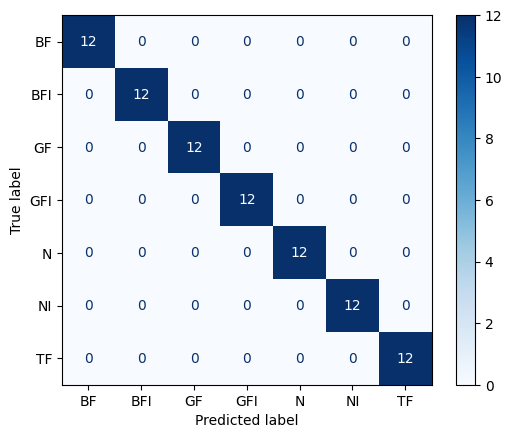

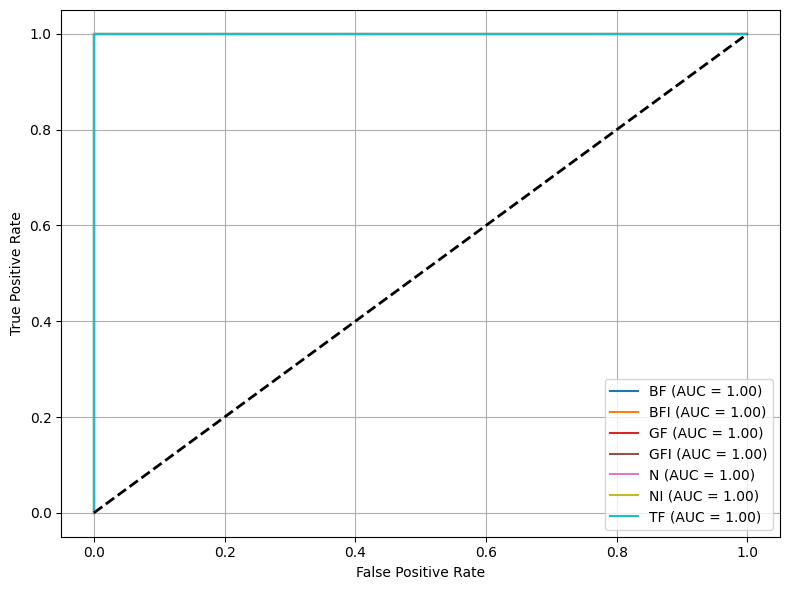

In [11]:
# ============================
# Step 7: Evaluation (Confusion Matrix & ROC)
# ============================
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = evaluate_model(student_model, labeled_loader, device)
print(classification_report(y_true, y_pred, target_names=list(class_to_idx.keys())))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred),
                              display_labels=list(class_to_idx.keys()))
disp.plot(cmap='Blues')
plt.show()


def plot_roc_curves(model, dataloader, class_names, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    y_true = label_binarize(all_labels, classes=range(len(class_names)))
    plt.figure(figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})', color=colors[i])
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curves(student_model, labeled_loader, list(class_to_idx.keys()), device)


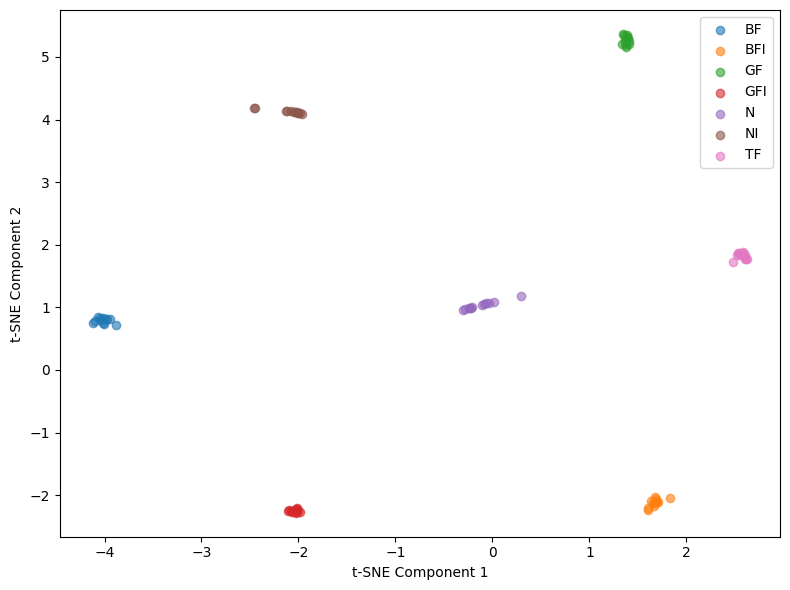

In [12]:

# ============================
# Step 8: t-SNE Visualization
# ============================
def plot_tsne(model, dataloader, device, class_names):
    model.eval()
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images, output_hidden_states=True)
            features = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
            all_features.append(features)
            all_labels.append(labels.cpu().numpy())
    all_features = np.vstack(all_features)
    all_labels = np.concatenate(all_labels)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(all_features)
    plt.figure(figsize=(8, 6))
    for idx, class_name in enumerate(class_names):
        indices = np.where(all_labels == idx)
        plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=class_name, alpha=0.6)
    plt.legend()
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.tight_layout()
    plt.show()

plot_tsne(student_model, labeled_loader, device, list(class_to_idx.keys()))